In [14]:
#5.3.1 Feature Extraction
import tensorflow as tf
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))


In [15]:
# Listing 5.17 Extracting features using the pretrained convolutional base
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# directories
base_dir = '/Users/roy/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000,4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
#Listing 5.18 Defining nad training the densely connected classifier
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Configure logging
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# tensorboard setup
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),   
              metrics=['accuracy'])

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features,validation_labels),
    callbacks=[tensorboard_callback],
    verbose=2)

2021-12-11 22:57:45.811109: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 22:57:45.811123: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 22:57:45.811243: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/30


2021-12-11 22:57:46.324451: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-11 22:57:46.324468: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-11 22:57:46.333358: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-11 22:57:46.334857: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


100/100 - 1s - loss: 0.6126 - accuracy: 0.6575 - val_loss: 0.8339 - val_accuracy: 0.5050
Epoch 2/30
100/100 - 1s - loss: 0.4303 - accuracy: 0.8145 - val_loss: 0.9956 - val_accuracy: 0.5010
Epoch 3/30
100/100 - 1s - loss: 0.3573 - accuracy: 0.8530 - val_loss: 1.1330 - val_accuracy: 0.4950
Epoch 4/30
100/100 - 1s - loss: 0.3229 - accuracy: 0.8650 - val_loss: 1.2331 - val_accuracy: 0.5080
Epoch 5/30
100/100 - 1s - loss: 0.2898 - accuracy: 0.8810 - val_loss: 1.3435 - val_accuracy: 0.5020
Epoch 6/30
100/100 - 1s - loss: 0.2624 - accuracy: 0.8985 - val_loss: 1.4285 - val_accuracy: 0.5040
Epoch 7/30
100/100 - 1s - loss: 0.2484 - accuracy: 0.9095 - val_loss: 1.4947 - val_accuracy: 0.5070
Epoch 8/30
100/100 - 1s - loss: 0.2331 - accuracy: 0.9140 - val_loss: 1.5529 - val_accuracy: 0.4980
Epoch 9/30
100/100 - 1s - loss: 0.2190 - accuracy: 0.9165 - val_loss: 1.6097 - val_accuracy: 0.4940
Epoch 10/30
100/100 - 1s - loss: 0.2025 - accuracy: 0.9245 - val_loss: 1.6871 - val_accuracy: 0.4990
Epoch 11/3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


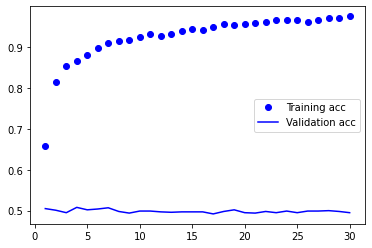

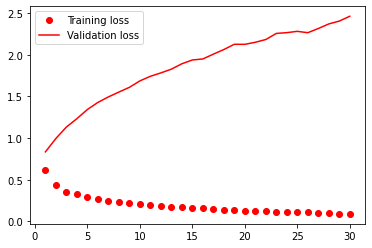

In [16]:
# Listing 5.19 Plotting the results
import matplotlib.pyplot as plt

print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_acc = range(1, len(acc) + 1)
epochs_val = range(1, len(val_acc) + 1)

plt.plot(epochs_acc, acc, 'bo', label='Training acc')
plt.plot(epochs_val, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()
plt.plot(epochs_acc, loss, 'ro', label='Training loss')
plt.plot(epochs_val, val_loss, 'r', label='Validation loss')
plt.legend()

plt.show()